### Import Libraries

In [1]:
import pandas as pd
import pathlib
from joblib import load

import sys
sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_cm

### Load Datasets

In [2]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/training_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)

### Specify Results Directory

In [3]:
# specify results directory
results_dir = pathlib.Path("evaluations/")
cm_dir = pathlib.Path(f"{results_dir}/confusion_matrices/")
cm_dir.mkdir(parents=True, exist_ok=True)

### Evaluate Each Model on Each Dataset

Evaluating model on dataset test


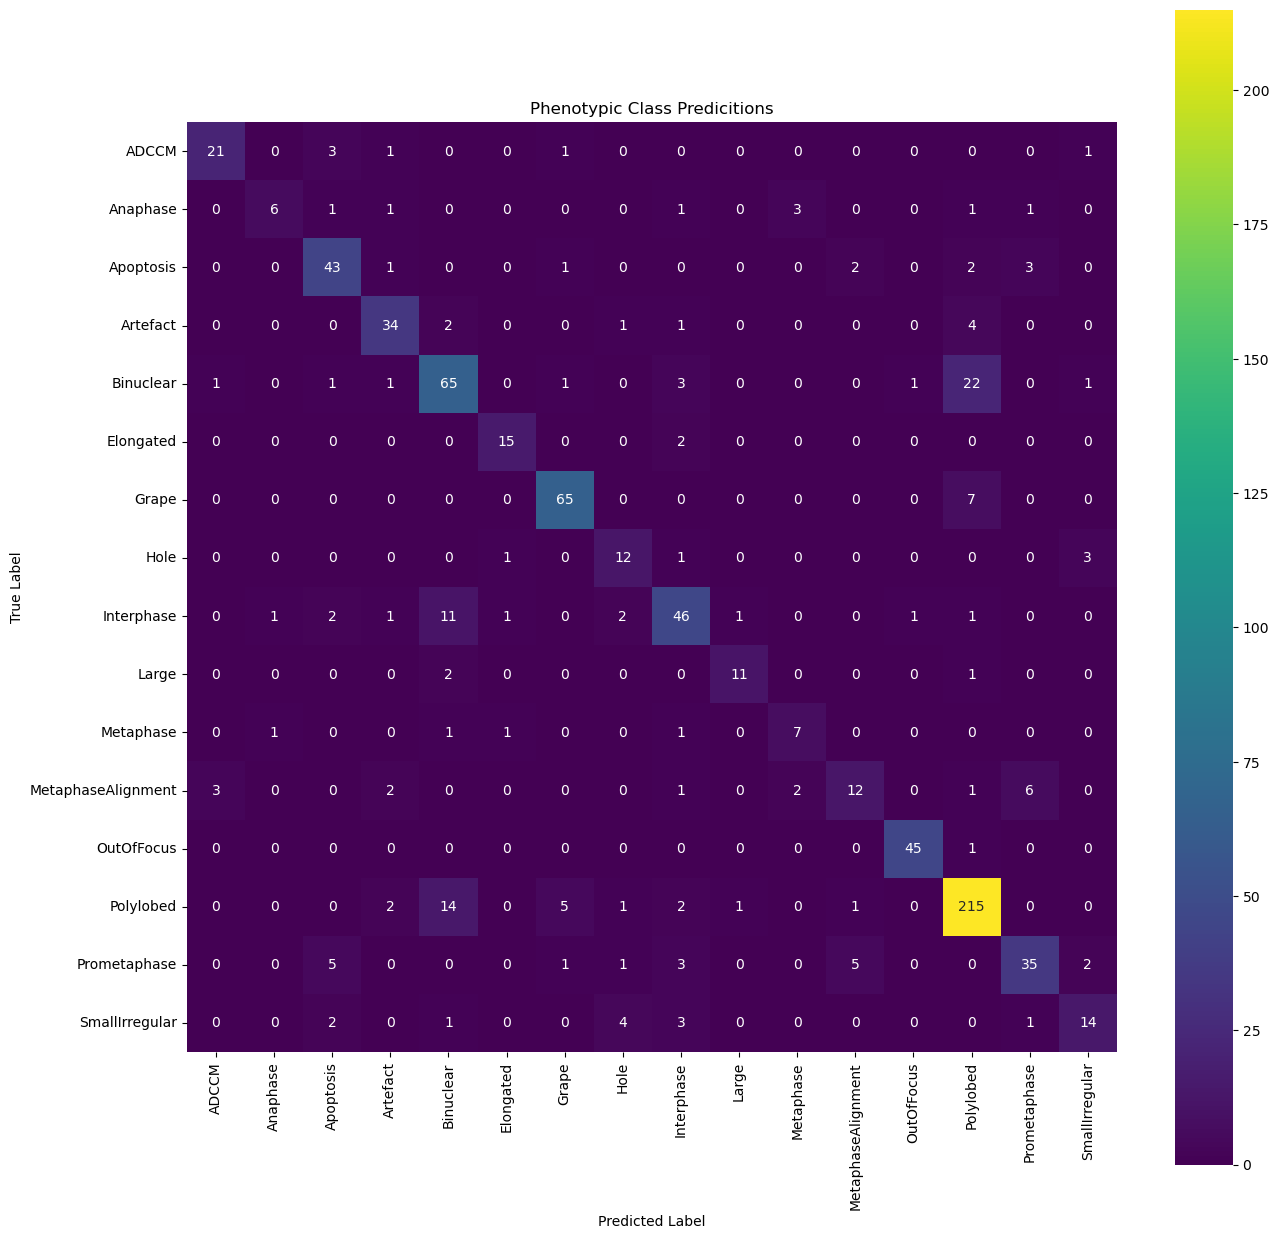

Evaluating model on dataset train


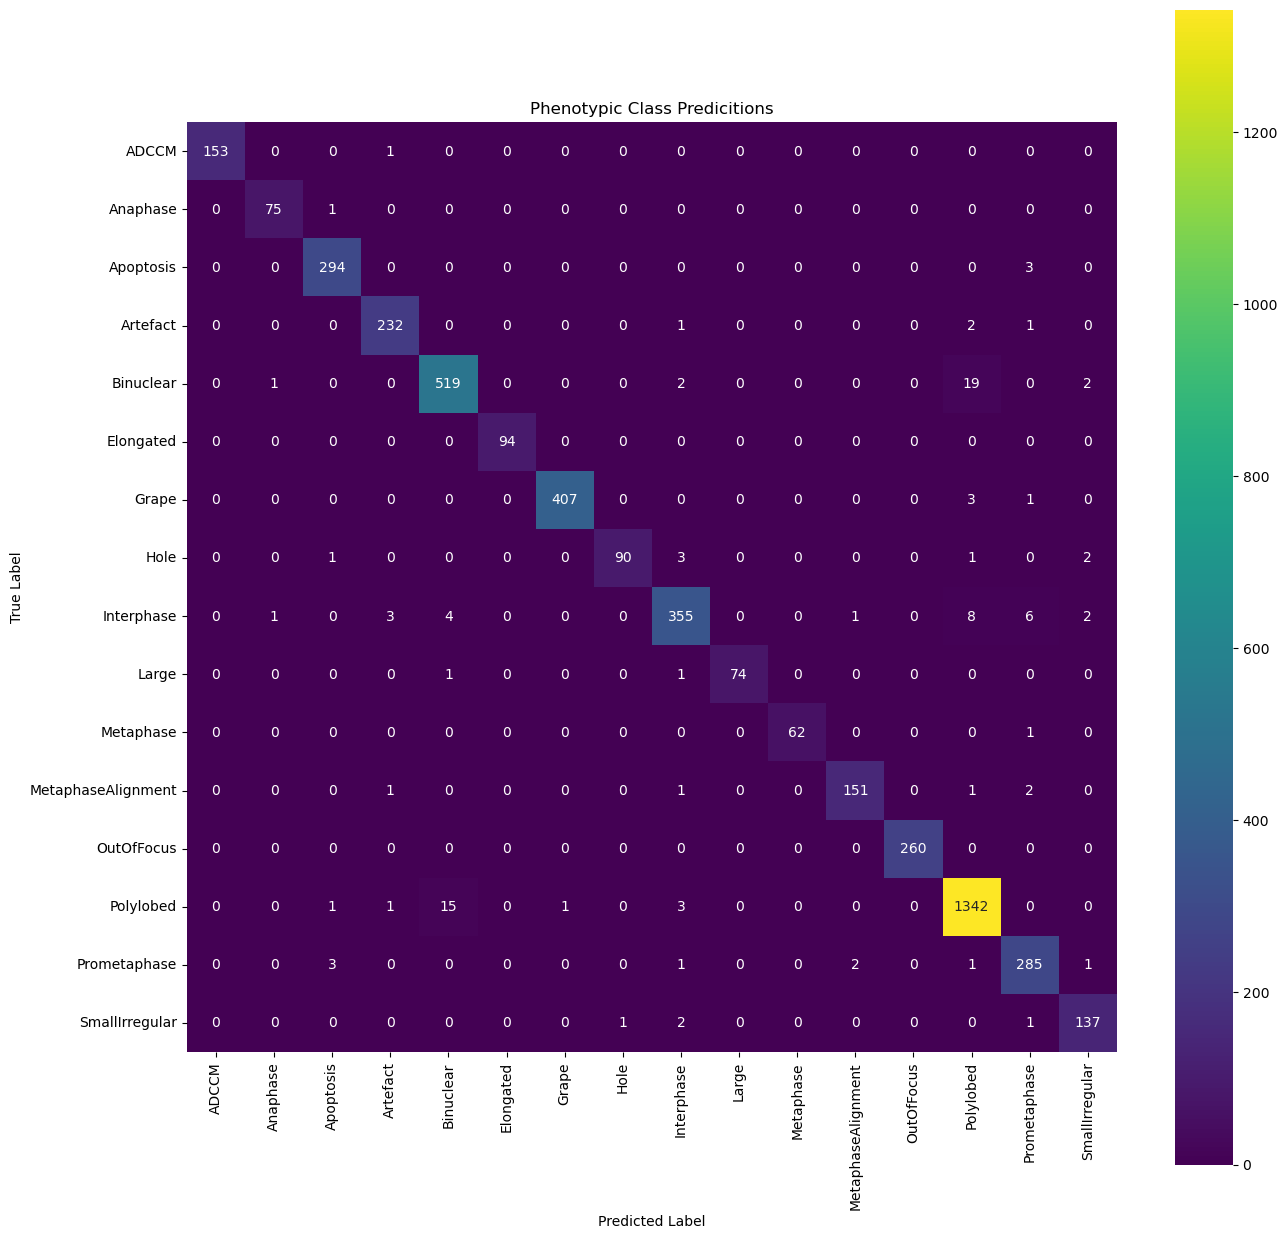

Evaluating shuffled_baseline_model on dataset test


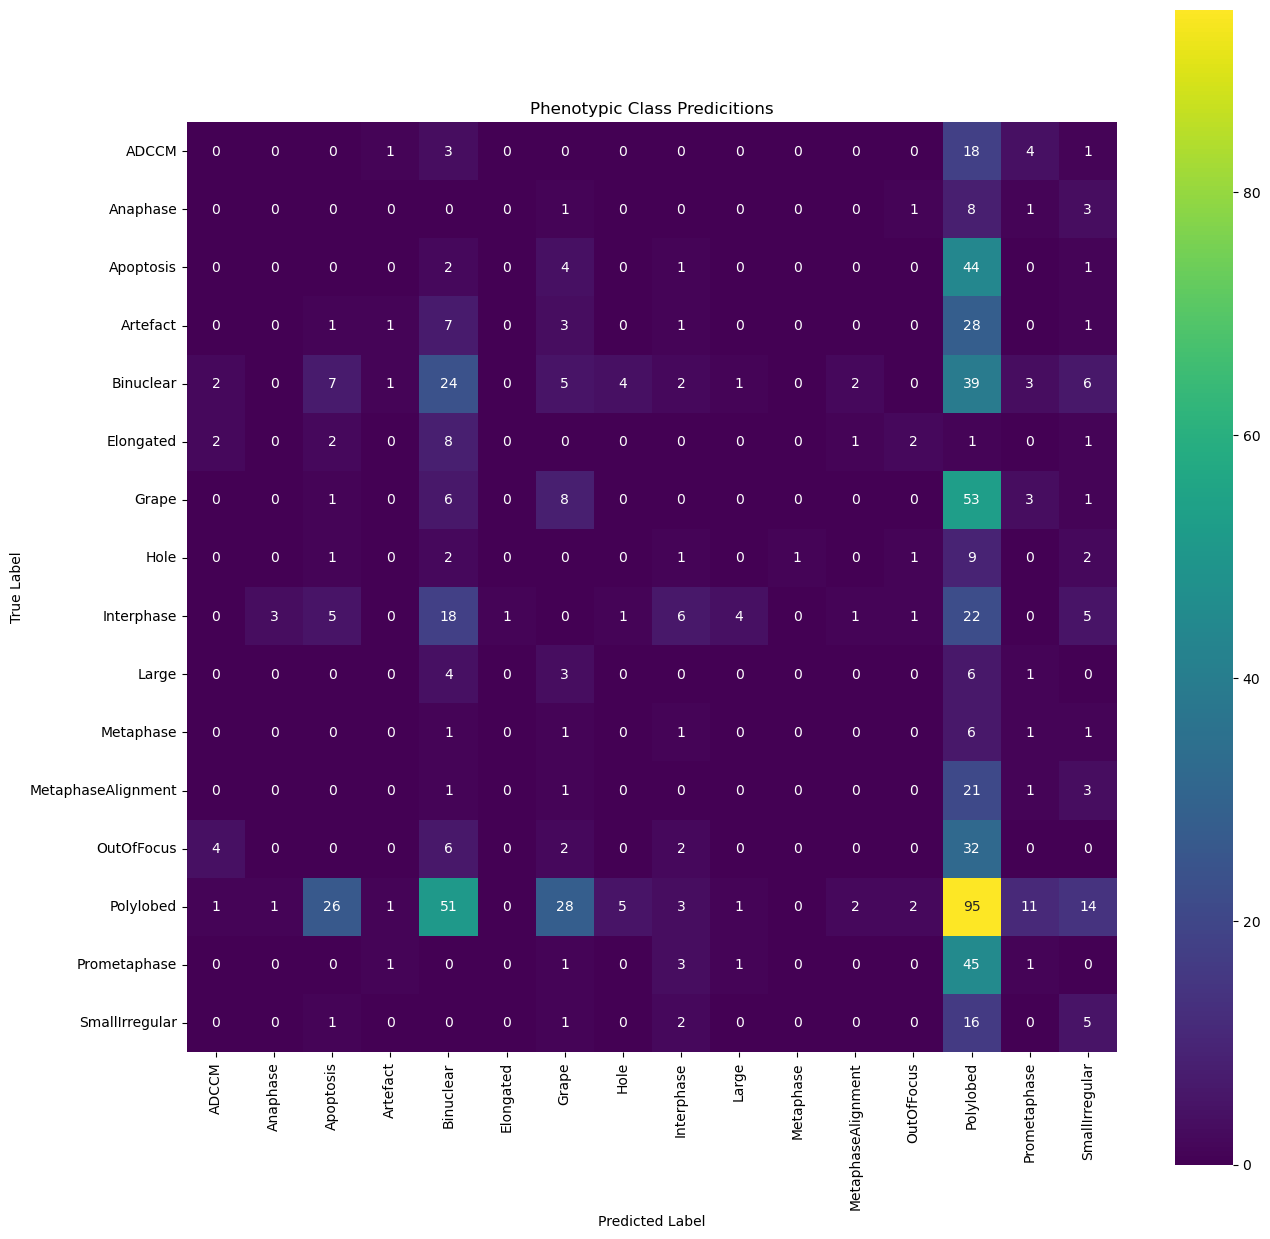

Evaluating shuffled_baseline_model on dataset train


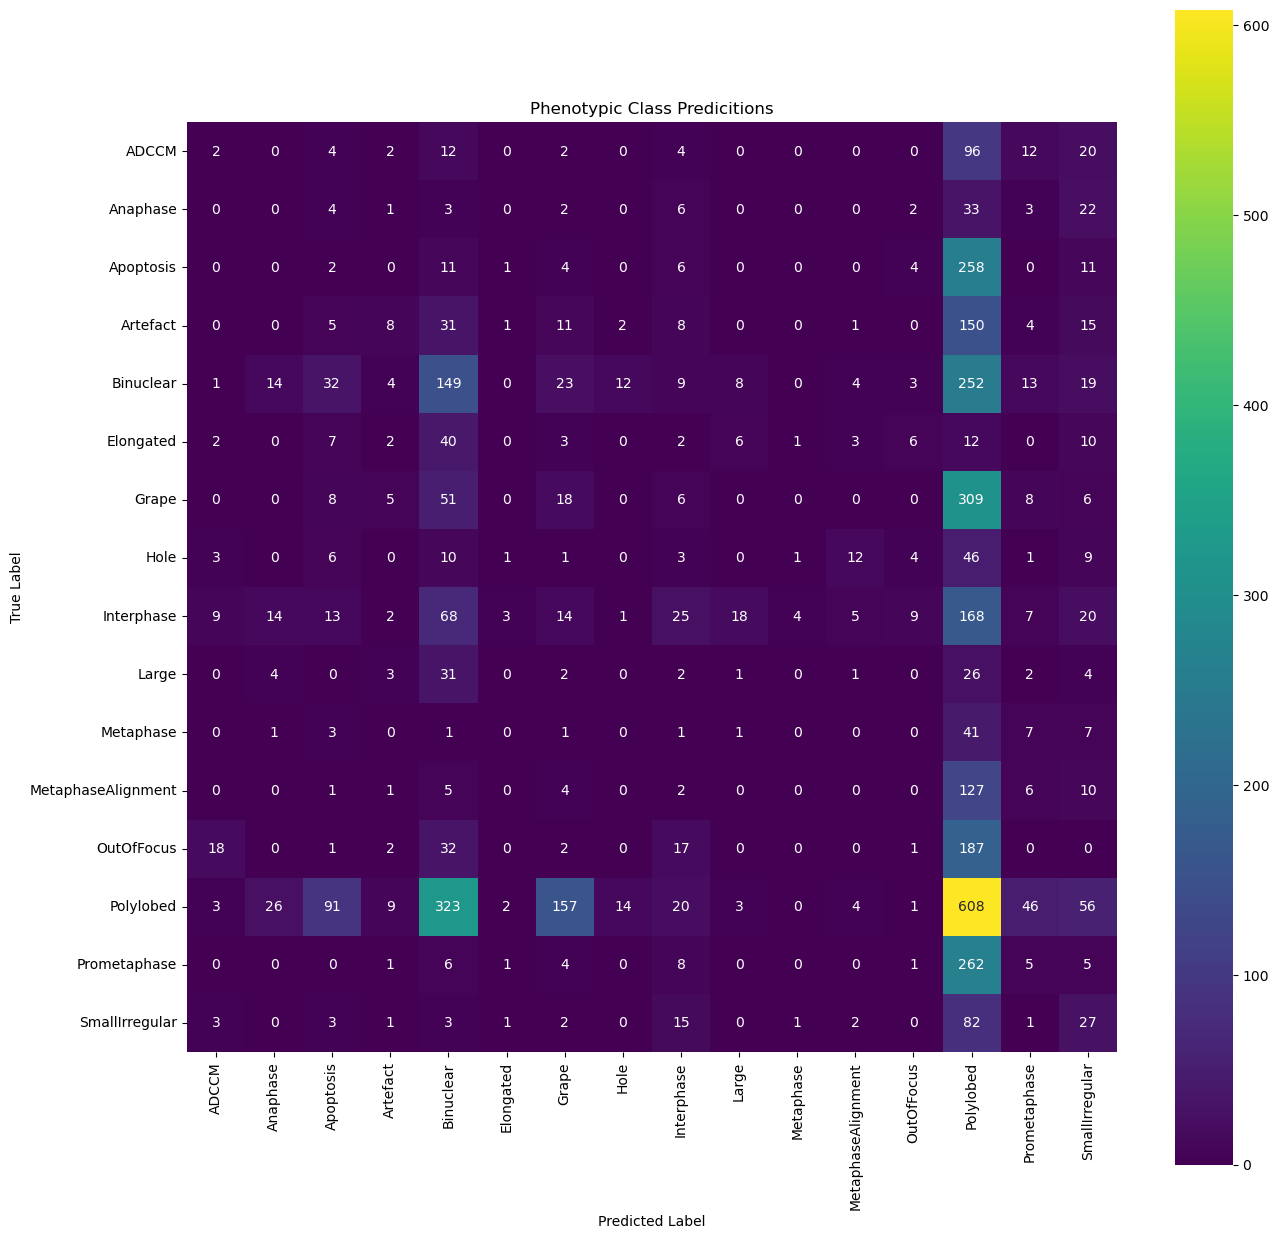

In [4]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# iterate through each model
for model_path in models_dir.iterdir():
    model = load(model_path)
    model_name = model_path.name.replace("log_reg_","").replace(".joblib","")
    
    # iterate through label datasets
    for label in data_split_indexes["label"].unique():
        print(f"Evaluating {model_name} on dataset {label}")
        
        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # path to save confusion matrix tidy data to
        cm_save_path = pathlib.Path(f"{cm_dir}/{model_name}_{label}_cm.tsv")
        
        cm = model_cm(model, data)
        
        cm_tidy_data = cm.stack()
        cm_tidy_data = pd.DataFrame(cm_tidy_data).reset_index(level=[0,1])
        cm_tidy_data.columns = ["True_Label", "Predicted_Label", "Count"]
        cm_tidy_data.to_csv(cm_save_path, sep="\t")